In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Sequential

In [3]:
data_dir = '/kaggle/input/combined-unknown-pneumonia-and-tuberculosis/data'

In [70]:
img_size = (150,150)
batch_size = 16
input_shape = (150,150,3)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'val'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(data_dir, 'test'),
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)
class_names = train_ds.class_names
print("Classes:", class_names)
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 13028 files belonging to 4 classes.
Found 761 files belonging to 4 classes.
Found 1527 files belonging to 4 classes.
Classes: ['NORMAL', 'PNEUMONIA', 'TUBERCULOSIS', 'UNKNOWN']


In [6]:
class KANLayer(tf.keras.layers.Layer):
    def __init__(self, units=64, activation="relu"):
        super(KANLayer, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.coefficients = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        x = tf.matmul(inputs, self.coefficients) + self.bias
        return self.activation(x)


In [7]:
img_size = (150, 150)
n_classes = 4
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(*img_size),
    layers.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2)
])

In [8]:
kan_model = Sequential([
    layers.Input(shape=(150, 150, 3)),
    resize_and_rescale,
    data_augmentation,
    layers.Flatten(),
    KANLayer(units=256, activation='relu'),
    KANLayer(units=128, activation='relu'),
    layers.Dropout(0.4),
    KANLayer(units=64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation='softmax')
])
kan_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
kan_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ kan_layer (KANLayer)                 │ (None, 256)                 │      17,280,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ kan_layer_1 (KANLayer)               │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ kan_layer_2 (KANLayer)               │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,325,828 (66.09 MB)

 Trainable params: 17,325,828 (66.09 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
kan_history = kan_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

Epoch 1/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 100s 23ms/step - accuracy: 0.3577 - loss: 1.3825 - val_accuracy: 0.5913 - val_loss: 1.0086
Epoch 2/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5138 - loss: 1.0763 - val_accuracy: 0.7306 - val_loss: 0.7398
Epoch 3/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6322 - loss: 0.8846 - val_accuracy: 0.7267 - val_loss: 0.6727
Epoch 4/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6846 - loss: 0.7783 - val_accuracy: 0.7714 - val_loss: 0.6372
Epoch 5/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7065 - loss: 0.7435 - val_accuracy: 0.7937 - val_loss: 0.5748
Epoch 6/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7278 - loss: 0.6972 - val_accuracy: 0.7989 - val_loss: 0.5658
Epoch 7/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7296 - loss: 0.6921 - val_accuracy: 0.7845 - val_loss: 0.6231
Epoch 8/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.7394 - loss: 0.6611 - val_accuracy:

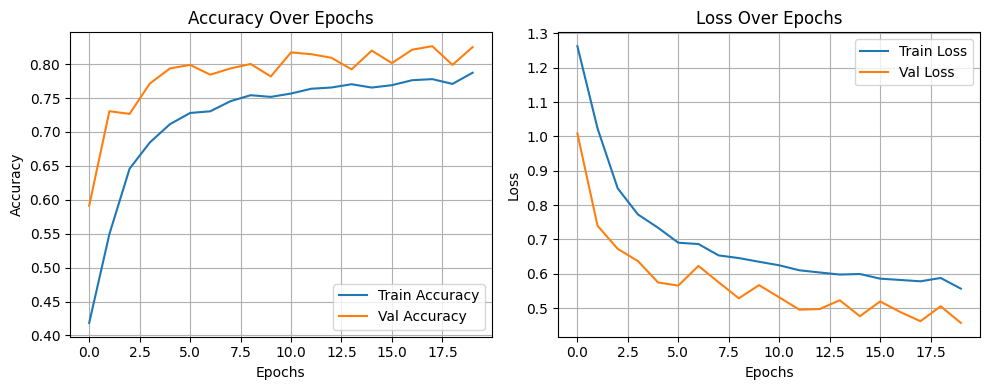

In [10]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(kan_history.history['accuracy'], label='Train Accuracy')
plt.plot(kan_history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(kan_history.history['loss'], label='Train Loss')
plt.plot(kan_history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Accuracy Score: 0.8166

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.73      0.90      0.80       548
   PNEUMONIA       0.89      0.81      0.85       427
TUBERCULOSIS       0.86      0.70      0.77       417
     UNKNOWN       0.97      0.84      0.90       135

    accuracy                           0.82      1527
   macro avg       0.86      0.81      0.83      1527
weighted avg       0.83      0.82      0.82      1527



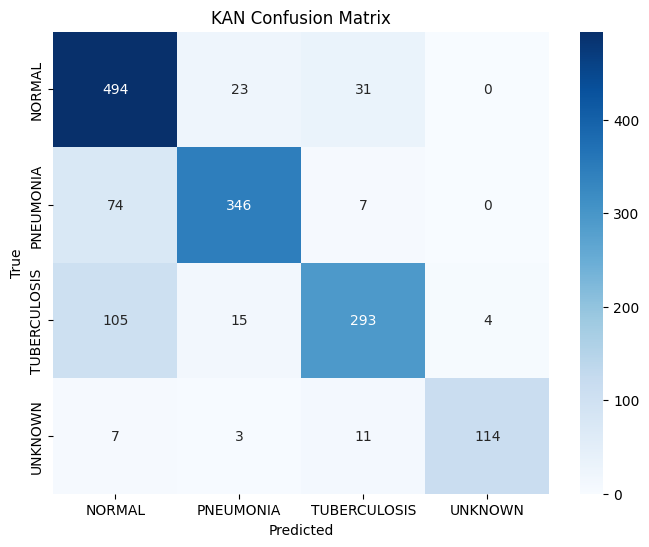

In [11]:
y_true = []
y_pred_probs = []
for images, labels in test_ds:
    preds = kan_model.predict(images, verbose=0)
    y_pred_probs.extend(preds)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)
y_pred = np.argmax(np.array(y_pred_probs), axis=1)
print(f"\nAccuracy Score: {accuracy_score(y_true, y_pred):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("KAN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [12]:
n_classes = 4 
CNN_KAN_model = tf.keras.Sequential([
    layers.Input(shape=(150, 150, 3)),
    resize_and_rescale,
    data_augmentation,
    # Block 1
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    # Block 2
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    # Block 3
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.35),
    # Block 4
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.GlobalAveragePooling2D(),
    # Dense (KAN) Layers
    KANLayer(units=1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    KANLayer(units=512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(n_classes, activation='softmax')
])
CNN_KAN_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)
CNN_KAN_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 150, 150, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 75, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 75, 75, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 37, 37, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 37, 37, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 37, 37, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 37, 37, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 18, 18, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 18, 18, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 18, 18, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,747,524 (21.93 MB)

 Trainable params: 5,742,532 (21.91 MB)

 Non-trainable params: 4,992 (19.50 KB)

In [13]:
CNN_KAN_history = CNN_KAN_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

Epoch 1/20


E0000 00:00:1745160880.702682      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_3_1/dropout_2_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1745160881.186343     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


408/408 ━━━━━━━━━━━━━━━━━━━━ 73s 147ms/step - accuracy: 0.5492 - loss: 1.2867 - val_accuracy: 0.2799 - val_loss: 8.7952
Epoch 2/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 142ms/step - accuracy: 0.7277 - loss: 0.7386 - val_accuracy: 0.3784 - val_loss: 7.2277
Epoch 3/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 142ms/step - accuracy: 0.7678 - loss: 0.6290 - val_accuracy: 0.4074 - val_loss: 5.3748
Epoch 4/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 142ms/step - accuracy: 0.8043 - loss: 0.5229 - val_accuracy: 0.4100 - val_loss: 4.3874
Epoch 5/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 142ms/step - accuracy: 0.8165 - loss: 0.4854 - val_accuracy: 0.4363 - val_loss: 4.8001
Epoch 6/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 142ms/step - accuracy: 0.8409 - loss: 0.4310 - val_accuracy: 0.6610 - val_loss: 1.2851
Epoch 7/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 141ms/step - accuracy: 0.8525 - loss: 0.3997 - val_accuracy: 0.6163 - val_loss: 1.3684
Epoch 8/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 58s 142ms/step - accuracy: 0.8589 - loss: 0.3690 - val

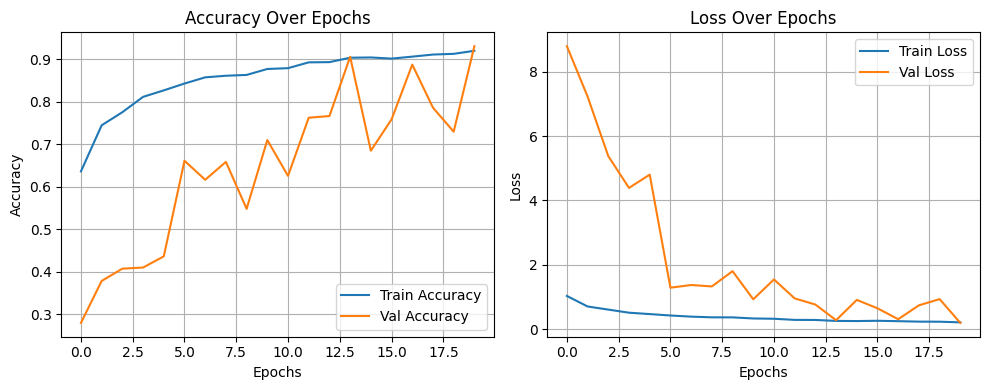

In [14]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(CNN_KAN_history.history['accuracy'], label='Train Accuracy')
plt.plot(CNN_KAN_history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(CNN_KAN_history.history['loss'], label='Train Loss')
plt.plot(CNN_KAN_history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Accuracy Score: 0.9234

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.93      0.87      0.90       548
   PNEUMONIA       0.88      0.98      0.93       427
TUBERCULOSIS       0.94      0.90      0.92       417
     UNKNOWN       1.00      1.00      1.00       135

    accuracy                           0.92      1527
   macro avg       0.94      0.94      0.94      1527
weighted avg       0.93      0.92      0.92      1527



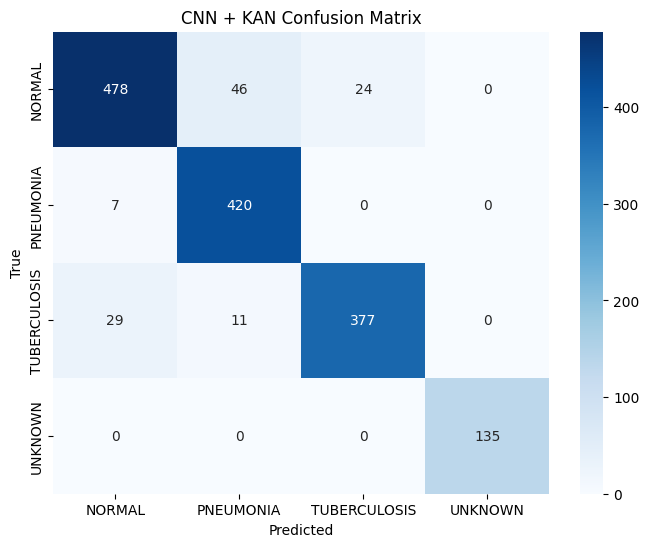

In [16]:
y_true = []
y_pred_probs = []

for images, labels in test_ds:
    preds = CNN_KAN_model.predict(images, verbose=0)
    y_pred_probs.extend(preds)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)
y_pred = np.argmax(np.array(y_pred_probs), axis=1)
print(f"\nAccuracy Score: {accuracy_score(y_true, y_pred):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("CNN + KAN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

CNN + KAN + ResNet

In [17]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
resnet_base = ResNet50V2(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
for layer in resnet_base.layers[:-30]:
    layer.trainable = False
for layer in resnet_base.layers[-30:]:
    layer.trainable = True

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [19]:
input_shape = (150,150,3)
CNN_KAN_ResNet_model = tf.keras.Sequential([
    layers.Input(shape=input_shape),

    # Preprocessing
    resize_and_rescale,
    data_augmentation,

    # Custom CNN Layers
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    # Resize & preprocess for ResNet
    layers.Conv2D(3, (1, 1), activation='relu'),
    layers.Resizing(150, 150),
    layers.Lambda(preprocess_input),

    # ResNet Feature Extractor
    resnet_base,
    layers.GlobalAveragePooling2D(),

    # KAN-style Dense Layers
    KANLayer(units=512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    KANLayer(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    KANLayer(units=128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    # Output Layer
    layers.Dense(n_classes, activation='softmax')
])
CNN_KAN_ResNet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
CNN_KAN_ResNet_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 150, 150, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 37, 37, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 37, 37, 3)           │             195 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_1 (Resizing)                │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 150, 150, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 5, 5, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ kan_layer_5 (KANLayer)               │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ kan_layer_6 (KANLayer)               │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │              

 Total params: 24,802,183 (94.61 MB)

 Trainable params: 15,678,919 (59.81 MB)

 Non-trainable params: 9,123,264 (34.80 MB)

In [20]:
CNN_KAN_ResNet_history = CNN_KAN_ResNet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    verbose=1
)

Epoch 1/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 71s 122ms/step - accuracy: 0.4095 - loss: 1.6579 - val_accuracy: 0.5138 - val_loss: 1.4207
Epoch 2/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 46s 113ms/step - accuracy: 0.6913 - loss: 0.8169 - val_accuracy: 0.8463 - val_loss: 0.4723
Epoch 3/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 46s 113ms/step - accuracy: 0.7745 - loss: 0.6141 - val_accuracy: 0.8541 - val_loss: 0.4155
Epoch 4/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 46s 113ms/step - accuracy: 0.8010 - loss: 0.5394 - val_accuracy: 0.8607 - val_loss: 0.3423
Epoch 5/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 46s 113ms/step - accuracy: 0.8150 - loss: 0.4818 - val_accuracy: 0.9067 - val_loss: 0.2644
Epoch 6/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 46s 113ms/step - accuracy: 0.8501 - loss: 0.3956 - val_accuracy: 0.8830 - val_loss: 0.2966
Epoch 7/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 46s 113ms/step - accuracy: 0.8516 - loss: 0.3868 - val_accuracy: 0.9080 - val_loss: 0.2216
Epoch 8/20
408/408 ━━━━━━━━━━━━━━━━━━━━ 46s 113ms/step - accuracy: 0.8616 - loss: 0

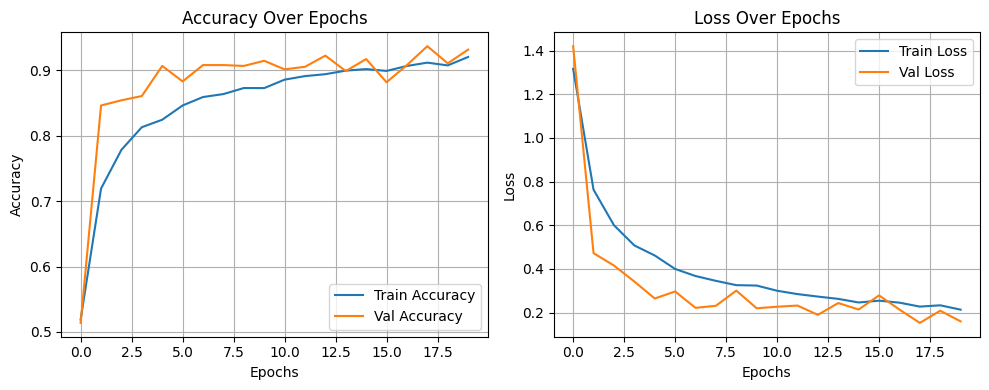

In [21]:
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(CNN_KAN_ResNet_history.history['accuracy'], label='Train Accuracy')
plt.plot(CNN_KAN_ResNet_history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(CNN_KAN_ResNet_history.history['loss'], label='Train Loss')
plt.plot(CNN_KAN_ResNet_history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Accuracy Score: 0.9411

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.95      0.89      0.92       548
   PNEUMONIA       0.97      0.96      0.97       427
TUBERCULOSIS       0.89      0.96      0.93       417
     UNKNOWN       0.99      1.00      0.99       135

    accuracy                           0.94      1527
   macro avg       0.95      0.95      0.95      1527
weighted avg       0.94      0.94      0.94      1527



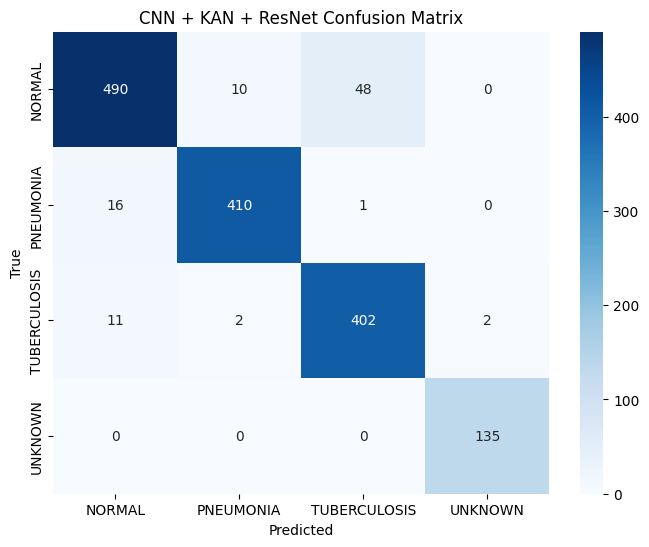

In [22]:
y_true = []
y_pred_probs = []
for images, labels in test_ds:
    preds = CNN_KAN_ResNet_model.predict(images, verbose=0)
    y_pred_probs.extend(preds)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
y_true = np.array(y_true)
y_pred = np.argmax(np.array(y_pred_probs), axis=1)
print(f"\nAccuracy Score: {accuracy_score(y_true, y_pred):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("CNN + KAN + ResNet Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()